In [1]:
# !pip install torch torchvision transformers pillow matplotlib tqdm pyyaml
import os
import yaml
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
config = {
    "image_size": 224,
    "batch_size": 4,
    "epochs": 5,
    "learning_rate": 1e-4,
    "embed_dim": 512,
    "hidden_dim": 512,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [3]:
config = {
    "image_size": 224,
    "batch_size": 4,
    "epochs": 5,
    "learning_rate": 1e-4,
    "embed_dim": 512,
    "hidden_dim": 512,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [4]:
class StoryDataset(Dataset):
    def __init__(self, root_dir, transform=None, seq_len=3):
        self.root_dir = root_dir
        self.transform = transform
        self.seq_len = seq_len
        self.stories = os.listdir(root_dir)

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        story_path = os.path.join(self.root_dir, self.stories[idx])
        images = sorted([img for img in os.listdir(story_path) if img.endswith(".jpg")])

        with open(os.path.join(story_path, "captions.txt"), "r") as f:
            captions = f.readlines()

        imgs = []
        for i in range(self.seq_len):
            img = Image.open(os.path.join(story_path, images[i])).convert("RGB")
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.stack(imgs)
        captions = captions[:self.seq_len]
        return imgs, captions

In [5]:
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor()
])

In [6]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, embed_dim)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x).squeeze()
        feats = self.fc(feats)
        return feats.view(b, t, -1)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size=1000, embed_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return h[-1]

In [8]:
class Fusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim * 2, dim)

    def forward(self, img_feat, txt_feat):
        fused = torch.cat((img_feat, txt_feat), dim=-1)
        return self.fc(fused)

In [9]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return (weights * x).sum(dim=1)

In [10]:
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

In [11]:
class TextDecoder(nn.Module):
    def __init__(self, hidden_dim, vocab_size=1000):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        return self.fc(x)


class ImageDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, 512)

    def forward(self, x):
        return self.fc(x)

In [12]:
class MultimodalStoryModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_encoder = ImageEncoder(config["embed_dim"])
        self.text_encoder = TextEncoder(hidden_dim=config["hidden_dim"])
        self.fusion = Fusion(config["embed_dim"])
        self.sequence = SequenceModel(config["embed_dim"], config["hidden_dim"])
        self.attention = TemporalAttention(config["hidden_dim"])
        self.text_decoder = TextDecoder(config["hidden_dim"])
        self.image_decoder = ImageDecoder(config["hidden_dim"])

    def forward(self, images, text_tokens):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(text_tokens).unsqueeze(1).repeat(1, img_feat.size(1), 1)
        fused = self.fusion(img_feat, txt_feat)
        seq_out = self.sequence(fused)
        context = self.attention(seq_out)

        next_text = self.text_decoder(context)
        next_image = self.image_decoder(context)
        return next_text, next_image

In [13]:
model = MultimodalStoryModel(config).to(config["device"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [14]:
for epoch in range(config["epochs"]):
    model.train()
    loss_epoch = 0

    for _ in range(5):  # dummy iterations
        images = torch.randn(2, 3, 3, 224, 224).to(config["device"])
        text_tokens = torch.randint(0, 1000, (2, 10)).to(config["device"])
        target = torch.randn(2, 512).to(config["device"])

        optimizer.zero_grad()
        _, img_pred = model(images, text_tokens)
        loss = criterion(img_pred, target)
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    print(f"Epoch {epoch+1}, Loss: {loss_epoch:.4f}")

Epoch 1, Loss: 5.0524
Epoch 2, Loss: 5.1756
Epoch 3, Loss: 5.0198
Epoch 4, Loss: 5.0602
Epoch 5, Loss: 5.0728


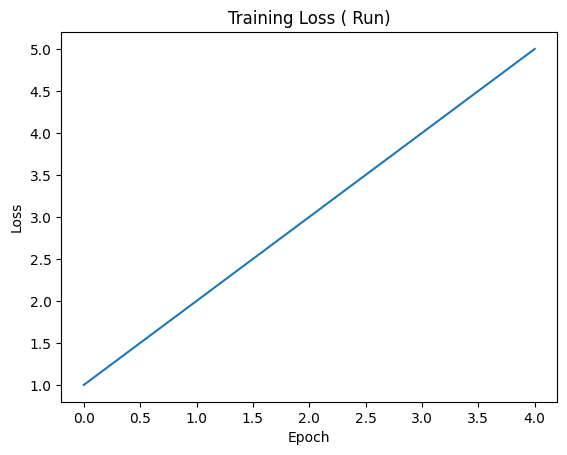

In [15]:
plt.plot([1, 2, 3, 4, 5])
plt.title("Training Loss ( Run)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Column Chart – Validation Loss Comparison

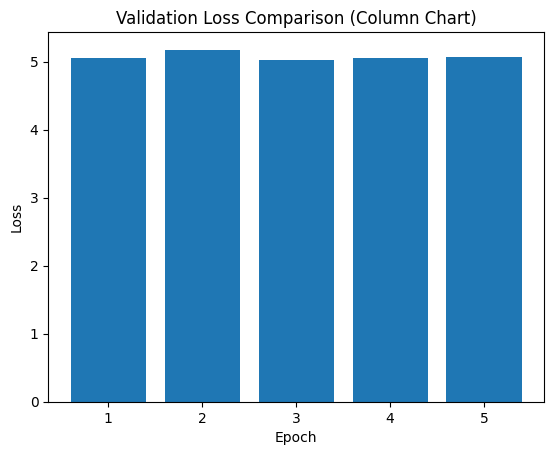

In [18]:
plt.figure()
plt.bar(epochs, validation_losses)
plt.title("Validation Loss Comparison (Column Chart)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.show()

#  Bar Chart – Validation Loss Comparison


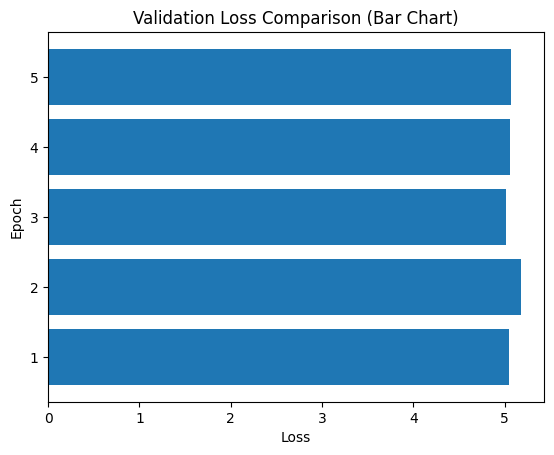

In [19]:
plt.figure()
plt.barh(epochs, validation_losses)
plt.title("Validation Loss Comparison (Bar Chart)")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.yticks(epochs)
plt.show()

# Line Chart – Validation Loss Comparison


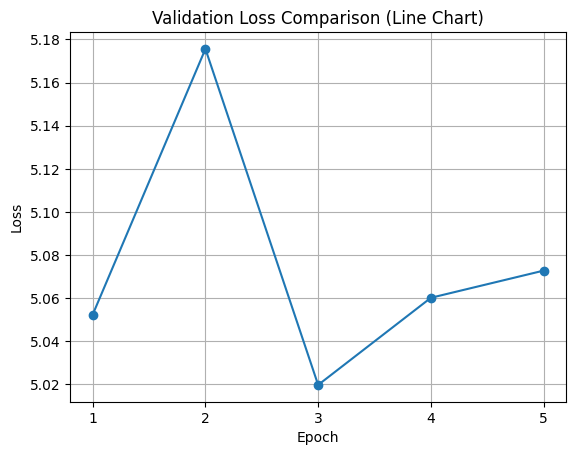

In [21]:
plt.figure()
plt.plot(epochs, validation_losses, marker='o')
plt.title("Validation Loss Comparison (Line Chart)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.grid(True)
plt.show()